In [ ]:
# MISSING VALUES -- Imputing :
    
# Categoric : Get the most frequent one of the features and fill with it.

# Numeric : SimpleImputer , kNN Imputer, Iterative Imputer,  MissingIndicator for both categoric and numeric.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn import datasets as dat
from sklearn import model_selection as mod
from sklearn import linear_model as lin
from sklearn import metrics as met
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
from sklearn import impute as imp
from sklearn import tree
from sklearn import ensemble as ens
from sklearn import compose as com


In [2]:
housing = dat.fetch_california_housing()

X = housing.data
y = housing.target

print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

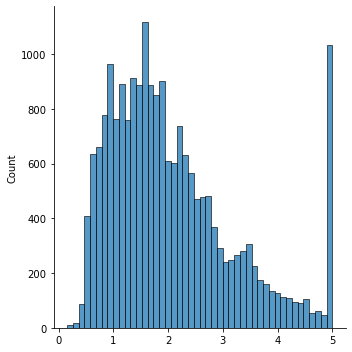

In [3]:
sns.displot(y)

In [4]:
# shuffle dataset
np.random.seed(42)
rnd_index = np.random.permutation(len(X))
X = X[rnd_index]    
y = y[rnd_index] 

In [5]:
ratio1 = 10

X = X[:int(len(X)/ratio1)]
y = y[:int(len(y)/ratio1)]

In [6]:
pd.DataFrame(X).isnull().sum() # how many null values does a feature has.

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

In [7]:
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2064 non-null   float64
 1   1       2064 non-null   float64
 2   2       2064 non-null   float64
 3   3       2064 non-null   float64
 4   4       2064 non-null   float64
 5   5       2064 non-null   float64
 6   6       2064 non-null   float64
 7   7       2064 non-null   float64
dtypes: float64(8)
memory usage: 129.1 KB


In [8]:
X_org = X.copy()
ratio2 = 5
num = (X.shape[0]*X.shape[1])//ratio2  #how many null values will I put into the features.
for i in range(num):
     rand_row = np.random.randint(0,X.shape[0])
     rand_col = np.random.randint(0,X.shape[1])
     while X[rand_row][rand_col] == np.nan :
         rand_row = np.random.randint(0,X.shape[0])
         rand_col = np.random.randint(0,X.shape[1])
     X[rand_row][rand_col] = np.nan

In [9]:
pd.DataFrame(X).isnull().sum()

0    357
1    389
2    385
3    396
4    358
5    367
6    367
7    385
dtype: int64

In [14]:
x_values = []
y_values = []

pipe_sgd = pip.Pipeline([
     ("scaler",pre.StandardScaler()),
     ("sgd",lin.SGDRegressor())
     ])

score = mod.cross_val_score(pipe_sgd,X_org,y,cv =3, scoring = "neg_root_mean_squared_error").mean() *-1
print(score)

0.9259203297982376


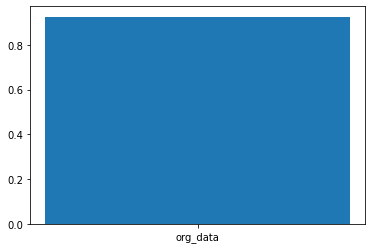

In [15]:
x_values.append("org_data")
y_values.append(score)

plt.bar(x_values,y_values)
plt.show()

In [16]:
for s in ["mean","median"]:
     pipe_sgd = pip.Pipeline([
         ("scaler",pre.StandardScaler()),
         ("imp",imp.SimpleImputer(strategy = s)),#put it after the scaling operation. does not matter for simple imputer but it differs for others. 
         # strategy = "constant",fill_value = 0
         ("sgd",lin.SGDRegressor()) 
         ])
    
     score = mod.cross_val_score(pipe_sgd,X,y,cv =3, scoring = "neg_root_mean_squared_error").mean() *-1
     x_values.append("SimpleImp_"+ s)
     y_values.append(score)

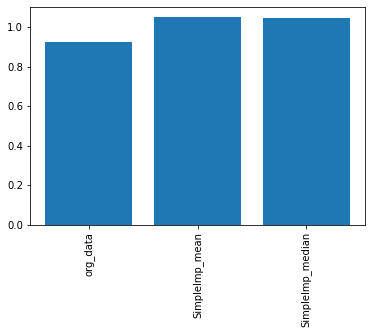

In [17]:
plt.bar(x_values,y_values)
plt.xticks(rotation = 90) # x eksenindeki yazıları rotate edip karışmamasını sağlamak için.
plt.show() #missing valueları doldurmazsan crossval den uyarı alırsın çalışmaz.

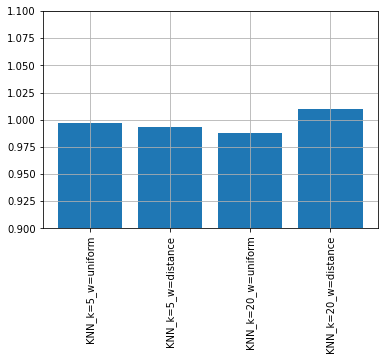

In [20]:
x_values = []
y_values = []

for k in [5,20]:
     for w in ["uniform","distance"]:
         pipe_sgd = pip.Pipeline([
             ("scaler",pre.StandardScaler()),
             ("imp",imp.KNNImputer(n_neighbors = k,weights = w)),
             ("sgd",lin.SGDRegressor()) 
             ])
        
         score = mod.cross_val_score(pipe_sgd,X,y,cv =3, scoring = "neg_root_mean_squared_error").mean() *-1
         x_values.append("KNN_k="+ str(k) + "_w=" + w)
         y_values.append(score)

plt.bar(x_values,y_values)
plt.xticks(rotation = 90) # rotate x axis 90 degree.
plt.grid(True)
plt.ylim(0.9,1.1)
plt.show()

In [ ]:
# ITERATIVE IMPUTER
 # Using a model to predict the missing values. 
 # After you predicted every points you start predicting them again because at first you used mean etc to fill the non-targeted missing values. it has a max iteration parameter.
 # You can use any model. Models like SGDRegressor will require Scaling. Also, it does not work with Categoric features.
 # imputation_order : ascending : it starts filling with the less missing columns.
    

In [24]:
x_values = []
y_values = []

for est in [lin.LinearRegression(),lin.SGDRegressor(random_state = 42),lin.BayesianRidge(),tree.DecisionTreeRegressor(random_state = 42)]:
     for order in ["ascending","descending"]:
         pipe_sgd = pip.Pipeline([
             ("scaler",pre.StandardScaler()),
             ("imp",imp.IterativeImputer(estimator = est ,imputation_order = order,max_iter = 5)),
             ("sgd",lin.SGDRegressor()) 
             ])
        
         score = mod.cross_val_score(pipe_sgd,X,y,cv =3, scoring = "neg_root_mean_squared_error").mean() *-1
         x_values.append("Iterative_est=" + est.__class__.__name__ + "_order=" + order)
         y_values.append(score) 

# you are using models to predict the missing values then you start training your data to predict y_test. Dont confuse, these two may not necessarily be the same.



In [28]:
x_values,y_values

(['Iterative_est=LinearRegression_order=ascending',
  'Iterative_est=LinearRegression_order=descending',
  'Iterative_est=SGDRegressor_order=ascending',
  'Iterative_est=SGDRegressor_order=descending',
  'Iterative_est=BayesianRidge_order=ascending',
  'Iterative_est=BayesianRidge_order=descending',
  'Iterative_est=DecisionTreeRegressor_order=ascending',
  'Iterative_est=DecisionTreeRegressor_order=descending'],
 [0.9579860089215043,
  0.9657626342846845,
  0.9566348090249873,
  0.9594551959284502,
  0.9702630674521567,
  0.9579513433674195,
  0.9562797698671622,
  0.9283835437714135])

In [33]:
best_score = min(y_values)
best_index = y_values.index(best_score)
x_values[best_index]

'Iterative_est=DecisionTreeRegressor_order=descending'

In [60]:
d = {
       "name" : ["Ahmet","Ali","Ayse","Fatma"],
       "city" : ["Istanbul","Izmir","np.nan","Istanbul"],
       "age"  : [20,30,np.nan,25],
       "salary": [np.nan,5000,7500,10000]
       }

data = pd.DataFrame(d)

In [48]:
data

,name,city,age,salary
0,Ahmet,Istanbul,20.0,NaN
1,Ali,Izmir,30.0,5000.0
2,Ayse,np.nan,NaN,7500.0
3,Fatma,Istanbul,25.0,10000.0


In [51]:
pipe_num = pip.Pipeline([
     ("scaler",pre.StandardScaler()),
     ("imp",imp.SimpleImputer(strategy = "mean"))
         ])

pipe_num.fit_transform(data.select_dtypes(exclude = object)) 

array([[-1.22474487,  0.        ],
       [ 1.22474487, -1.22474487],
       [ 0.        ,  0.        ],
       [ 0.        ,  1.22474487]])

In [52]:
pipe_cat= pip.Pipeline([
     ("imp",imp.SimpleImputer(strategy = "most_frequent")),
     ("one_hot", pre.OneHotEncoder(handle_unknown = "error")) 
     ])

pipe_cat.fit_transform(data.select_dtypes(include = "object")) 


<4x7 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [63]:
# COLUMN TRANSFORM:
# You try to use different imputing methods to different columns. Then you can use column Transformer.

ct = com.ColumnTransformer([
     ("num", pipe_num, ["age","salary"]),
     ("cat",pipe_cat,["name","city"])
     ],remainder = "passthrough") 
# by default drops remainder columns. You have to define remainder parameter according to your needs. 

ct.fit_transform(data) # the order will be age,salary,name and city.


array([[-1.22474487,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ],
       [ 1.22474487, -1.22474487,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.22474487,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ]])